<a target="_blank" href="https://colab.research.google.com/github/TuragaLab/jhu-janelia-2023-ml-demo/blob/main/demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Learning Demo

**Adapted from Neuromatch Academy**

__Original Content creators:__ Shubh Pachchigar, Vladimir Haltakov, Matthew Sargent, Konrad Kording

__Original Content reviewers:__ Deepak Raya, Siwei Bai, Kelson Shilling-Scrivo

__Original Content editors:__ Anoop Kulkarni, Spiros Chavlis

__Original Production editors:__ Arush Tagade, Spiros Chavlis

---
## Tutorial Objectives

* Learn to use PyTorch
* Learn how to design a neural network architecture to solve a problem
* Learn about training neural networks with stochastic gradient descent

## A note about the videos in this notebook
The videos in this notebook are from the Neuromatch course, and so they talk about
some things that aren't relevant to us here. But we've left them in just in case you want to take a look later.
You can also always check out the original Neuromatch deep learning course materials
in their entirety [here](https://deeplearning.neuromatch.io/tutorials/intro.html). Another nice set of practical course
materials is the [FastAI course](https://course.fast.ai/), which approaches things from more of a programmer's perspective.
The very bottom of this notebook has a more comprehensive list of resources.

---
# Setup

These first few cells are just pulling in all the libraries we'll be using to build neural networks and make visualizations of our data. **You have to run these first** but otherwise you can ignore these and skip to Section 1.

In [ ]:
# @title Install dependencies
!pip install pandas --quiet

In [1]:
# Imports
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# PyTorch libraries
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Random Number Seeds
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    _ = torch.manual_seed(seed)

In [4]:
# @title Helper Functions

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

# Code adapted from this notebook: https://jonchar.net/notebooks/Artificial-Neural-Network-with-Keras/

from pathlib import Path

def plot_decision_boundary(model, X, y, device):
  """
  Helper function to plot decision boundary

  Args:
    model: nn.module
      NaiveNet instance
    X: torch.tensor
      Input CIFAR10 data
    y: torch.tensor
      Class Labels/Targets
    device: String
      "cpu" or "cuda"

  Returns:
    Nothing
  """
  # Transfer the data to the CPU
  X = X.cpu().numpy()
  y = y.cpu().numpy()

  # Check if the frames folder exists and create it if needed
  frames_path = Path("frames")
  if not frames_path.exists():
    frames_path.mkdir()

  # Set min and max values and give it some padding
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.01

  # Generate a grid of points with distance h between them
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Predict the function value for the whole gid
  grid_points = np.c_[xx.ravel(), yy.ravel()]
  grid_points = torch.from_numpy(grid_points).type(torch.FloatTensor)
  Z = model.predict(grid_points.to(device)).cpu().numpy()
  Z = Z.reshape(xx.shape)

  # Plot the contour and training examples
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.binary)

**Important note: Colab users**

*Scratch Code Cells*

If you want to quickly try out something or take a look at the data, you can use scratch code cells. They allow you to run Python code, but will not mess up the structure of your notebook.

To open a new scratch cell go to *Insert* → *Scratch code cell*.

---
# Section 1: The Basics of PyTorch

**Note**: This section will mostly walk you through manipulating multidimensional arrays in PyTorch, so **you can feel free to just skip to the exercises in the next section** unless you're curious.
We do recommend keeping the [documentation for PyTorch](https://pytorch.org/docs/stable/index.html) open on the side.

PyTorch is a Python-based scientific computing package targeted at two sets of
audiences:

-  A replacement for NumPy optimized for the power of GPUs
-  A deep learning platform that provides significant flexibility
   and speed

At its core, PyTorch provides a few key features:

- A multidimensional [Tensor](https://pytorch.org/docs/stable/tensors.html) object, similar to a [NumPy Array](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.html) or a [MATLAB array](https://www.mathworks.com/help/matlab/learn_matlab/matrices-and-arrays.html) but with **GPU acceleration**.
- An optimized **autograd** engine for automatically computing derivatives.
- A clean, modular API for building and deploying **deep learning models**.

You can find more information about PyTorch in the Appendix.

# Section 1.1: Creating Tensors


In [5]:
# @title Video 3: Making Tensors
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'jGKd_4tPGrw'), ('Bilibili', 'BV1Rw411d7Uy')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

There are various ways of creating tensors, and when doing any real deep learning project, we will usually have to do so.

**Construct tensors directly:**

---



In [ ]:
# We can construct a tensor directly from some common python iterables,
# such as list and tuple nested iterables can also be handled as long as the
# dimensions are compatible

# tensor from a list
a = torch.tensor([0, 1, 2])

#tensor from a tuple of tuples
b = ((1.0, 1.1), (1.2, 1.3))
b = torch.tensor(b)

# tensor from a numpy array
c = np.ones([2, 3])
c = torch.tensor(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")

**Some common tensor constructors:**

---

In [ ]:
# The numerical arguments we pass to these constructors
# determine the shape of the output tensor

x = torch.ones(5, 3)
y = torch.zeros(2)
z = torch.empty(1, 1, 5)
print(f"Tensor x: {x}")
print(f"Tensor y: {y}")
print(f"Tensor z: {z}")

Notice that `.empty()` does not return zeros, but seemingly random numbers. Unlike `.zeros()`, which initialises the elements of the tensor with zeros, `.empty()` just allocates the memory. It is hence a bit faster if you are looking to just create a tensor.

**Creating random tensors and tensors like other tensors:**

---

In [ ]:
# There are also constructors for random numbers

# Uniform distribution
a = torch.rand(1, 3)

# Normal distribution
b = torch.randn(3, 4)

# There are also constructors that allow us to construct
# a tensor according to the above constructors, but with
# dimensions equal to another tensor.

c = torch.zeros_like(a)
d = torch.rand_like(c)

print(f"Tensor a: {a}")
print(f"Tensor b: {b}")
print(f"Tensor c: {c}")
print(f"Tensor d: {d}")

## Section 1.2: Operations in PyTorch

**Tensor-Tensor operations**

We can perform operations on tensors using methods under `torch.`

In [6]:
# @title Video 4: Tensor Operators
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'R1R8VoYXBVA'), ('Bilibili', 'BV1G44y127As')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Tensor-Tensor operations**

We can perform operations on tensors using methods under `torch.`.

In [ ]:
a = torch.ones(5, 3)
b = torch.rand(5, 3)
c = torch.empty(5, 3)
d = torch.empty(5, 3)

# this only works if c and d already exist
torch.add(a, b, out=c)

# Pointwise Multiplication of a and b
torch.multiply(a, b, out=d)

print(c)
print(d)

However, in PyTorch, most common Python operators are overridden.
The common standard arithmetic operators ($+$, $-$, $*$, $/$, and $**$) have all been lifted to elementwise operations

In [ ]:
x = torch.tensor([1, 2, 4, 8])
y = torch.tensor([1, 2, 3, 4])
x + y, x - y, x * y, x / y, x**y  # The `**` is the exponentiation operator

**Tensor Methods**

Tensors also have a number of common arithmetic operations built in. A full list of **all** methods can be found in the [official PyTorch docs](https://pytorch.org/docs/stable/tensors.html#tensor-class-reference).

All of these operations should have similar syntax to their numpy equivalents (feel free to skip if you already know this!).

In [ ]:
x = torch.rand(3, 3)
print(x)
print("\n")
# sum() - note the axis is the axis you move across when summing
print(f"Sum of every element of x: {x.sum()}")
print(f"Sum of the columns of x: {x.sum(axis=0)}")
print(f"Sum of the rows of x: {x.sum(axis=1)}")
print("\n")

print(f"Mean value of all elements of x {x.mean()}")
print(f"Mean values of the columns of x {x.mean(axis=0)}")
print(f"Mean values of the rows of x {x.mean(axis=1)}")

**Matrix Operations**

The `@` symbol is overridden to represent matrix multiplication. You can also use `torch.matmul()` to multiply tensors. For dot multiplication, you can use `torch.dot()`, or manipulate the axes of your tensors and do matrix multiplication (we will cover that in the next section).

Transposes of 2D tensors are obtained using `torch.t()` or `Tensor.T`. Note the lack of brackets for `Tensor.T` - it is an attribute, not a method.



## Section 1.3 Manipulating Tensors in Pytorch

In [7]:
# @title Video 5: Tensor Indexing
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0d0KSJ3lJbg'), ('Bilibili', 'BV1BM4y1K7pD')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

**Indexing**

Just as in numpy, elements in a tensor can be accessed by index. As in any numpy array, the first element has index 0 and ranges are specified to include the first to last_element-1. We can access elements according to their relative position to the end of the list by using negative indices. Indexing is also referred to as slicing.

For example, `[-1]` selects the last element; `[1:3]` selects the second and the third elements, and `[:-2]` will select all elements excluding the last and second-to-last elements.

In [ ]:
x = torch.arange(0, 10)
print(x)
print(x[-1])
print(x[1:3])
print(x[:-2])

When we have multidimensional tensors, indexing rules work the same way as NumPy.

In [ ]:
# make a 5D tensor
x = torch.rand(1, 2, 3, 4, 5)

print(f" shape of x[0]:{x[0].shape}")
print(f" shape of x[0][0]:{x[0][0].shape}")
print(f" shape of x[0][0][0]:{x[0][0][0].shape}")

**Flatten and reshape**

There are various methods for reshaping tensors. It is common to have to express 2D data in 1D format. Similarly, it is also common to have to reshape a 1D tensor into a 2D tensor. We can achieve this with the `.flatten()` and `.reshape()` methods.

In [ ]:
z = torch.arange(12).reshape(6, 2)
print(f"Original z: \n {z}")

# 2D -> 1D
z = z.flatten()
print(f"Flattened z: \n {z}")

# and back to 2D
z = z.reshape(3, 4)
print(f"Reshaped (3x4) z: \n {z}")

You will also see the `.view()` methods used a lot to reshape tensors. There is a subtle difference between `.view()` and `.reshape()`, though for now we will just use `.reshape()`. The documentation can be found in the Appendix.

**Squeezing tensors**

When processing batches of data, you will quite often be left with singleton dimensions. E.g., `[1,10]` or `[256, 1, 3]`. This dimension can quite easily mess up your matrix operations if you don't plan on it being there...

In order to compress tensors along their singleton dimensions we can use the `.squeeze()` method. We can use the `.unsqueeze()` method to do the opposite.

In [ ]:
x = torch.randn(1, 10)
# printing the zeroth element of the tensor will not give us the first number!

print(x.shape)
print(f"x[0]: {x[0]}")

Because of that pesky singleton dimension, `x[0]` gave us the first row instead!

In [ ]:
# Let's get rid of that singleton dimension and see what happens now
x = x.squeeze(0)
print(x.shape)
print(f"x[0]: {x[0]}")

In [ ]:
# Adding singleton dimensions works a similar way, and is often used when tensors
# being added need same number of dimensions

y = torch.randn(5, 5)
print(f"Shape of y: {y.shape}")

# lets insert a singleton dimension
y = y.unsqueeze(1)
print(f"Shape of y: {y.shape}")

**Permutation**

Sometimes our dimensions will be in the wrong order! For example, we may be dealing with RGB images with dim $[3\times48\times64]$, but our pipeline expects the colour dimension to be the last dimension, i.e., $[48\times64\times3]$. To get around this we can use the `.permute()` method.

In [ ]:
# `x` has dimensions [color,image_height,image_width]
x = torch.rand(3, 48, 64)

# We want to permute our tensor to be [ image_height , image_width , color ]
x = x.permute(1, 2, 0)
# permute(1,2,0) means:
# The 0th dim of my new tensor = the 1st dim of my old tensor
# The 1st dim of my new tensor = the 2nd
# The 2nd dim of my new tensor = the 0th
print(x.shape)

You may also see `.transpose()` used. This works in a similar way as permute, but can only swap two dimensions at once.

**Concatenation**

In this example, we concatenate two matrices along rows (axis 0, the first element of the shape) vs. columns (axis 1, the second element of the shape). We can see that the first output tensor’s axis-0 length (`6`) is the sum of the two input tensors’ axis-0 lengths (`3+3`); while the second output tensor’s axis-1 length (`8`) is the sum of the two input tensors’ axis-1 lengths (`4+4`).

In [ ]:
# Create two tensors of the same shape
x = torch.arange(12, dtype=torch.float32).reshape((3, 4))
y = torch.tensor([[2.0, 1, 4, 3], [1, 2, 3, 4], [4, 3, 2, 1]])

# Concatenate along rows
cat_rows = torch.cat((x, y), dim=0)

# Concatenate along columns
cat_cols = torch.cat((x, y), dim=1)

# Printing outputs
print('Concatenated by rows: shape{} \n {}'.format(list(cat_rows.shape), cat_rows))
print('\n Concatenated by colums: shape{}  \n {}'.format(list(cat_cols.shape), cat_cols))

**Conversion to Other Python Objects**

Converting a tensor to a numpy.ndarray, or vice versa, is easy, and the converted result does not share memory. This minor inconvenience is quite important: when you perform operations on the CPU or GPUs, you do not want to halt computation, waiting to see whether the NumPy package of Python might want to be doing something else with the same chunk of memory.

When converting to a NumPy array, the information being tracked by the tensor will be lost, i.e., the computational graph. This will be covered in detail when you are introduced to autograd tomorrow!

In [ ]:
x = torch.randn(5)
print(f"x: {x}  |  x type:  {x.type()}")

y = x.numpy()
print(f"y: {y}  |  y type:  {type(y)}")

z = torch.tensor(y)
print(f"z: {z}  |  z type:  {z.type()}")

To convert a size-1 tensor to a Python scalar, we can invoke the item function or Python’s built-in functions.

In [ ]:
a = torch.tensor([3.5])
a, a.item(), float(a), int(a)

To convert between types, e.g. 32 bit floats or 64 bit floats or integers and so on, we can use the `.to()` method on a tensor:

In [ ]:
x = torch.randn(5)
print(f"x: {x}  |  x type:  {x.type()}")

y = x.to(torch.float64)
print(f"y: {y}  |  y type:  {y.type()}")

z = (255 * x).to(torch.int8)
print(f"z: {z}  |  z type:  {z.type()}")

To move a tensor from the CPU to the GPU, we can use the `.to()` method again, but this time with a special string:

In [ ]:
x = torch.randn(5)
print(f"x: {x}  |  x device:  {x.device}")

x = x.to("cuda")
print(f"x: {x}  |  x device:  {x.device}")

You'll usually want to keep all your tensors on the GPU in order to make training and inference of neural networks fast!

---
# Section 2: Neural Networks

Now it's time for you to create your first neural network using PyTorch. This section will walk you through the process of:

1. Creating a simple binary classification neural network model with linear layers
2. Training the network
3. Visualizing the results of the network
4. Tweaking the network to improve performance

In [8]:
# @title Video 10: CSV Files
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'JrC_UAJWYKU'), ('Bilibili', 'BV1xy4y1T7kv')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

## Section 2.1: Data Loading

First we need some sample data to train our network on. You can use the function below to generate an example dataset consisting of 2D points along two interleaving half circles. The data will be stored in a file called `sample_data.csv`. You can inspect the file directly in Colab by going to Files on the left side and opening the CSV file.

In [9]:
# @title Generate sample data
# @markdown we used `scikit-learn` module
from sklearn.datasets import make_moons

# Create a dataset of 1024 points with a little noise
X, y = make_moons(1024, noise=0.1)

# Store the data as a Pandas data frame and save it to a CSV file
df = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], y=y))
df.to_csv('sample_data.csv')

Now we can load the data from the CSV file using the Pandas library. Pandas provides many functions for reading files in various formats. When loading data from a CSV file, we can reference the columns directly by their names.

Size X:(1024, 2)
Size y:(1024,)


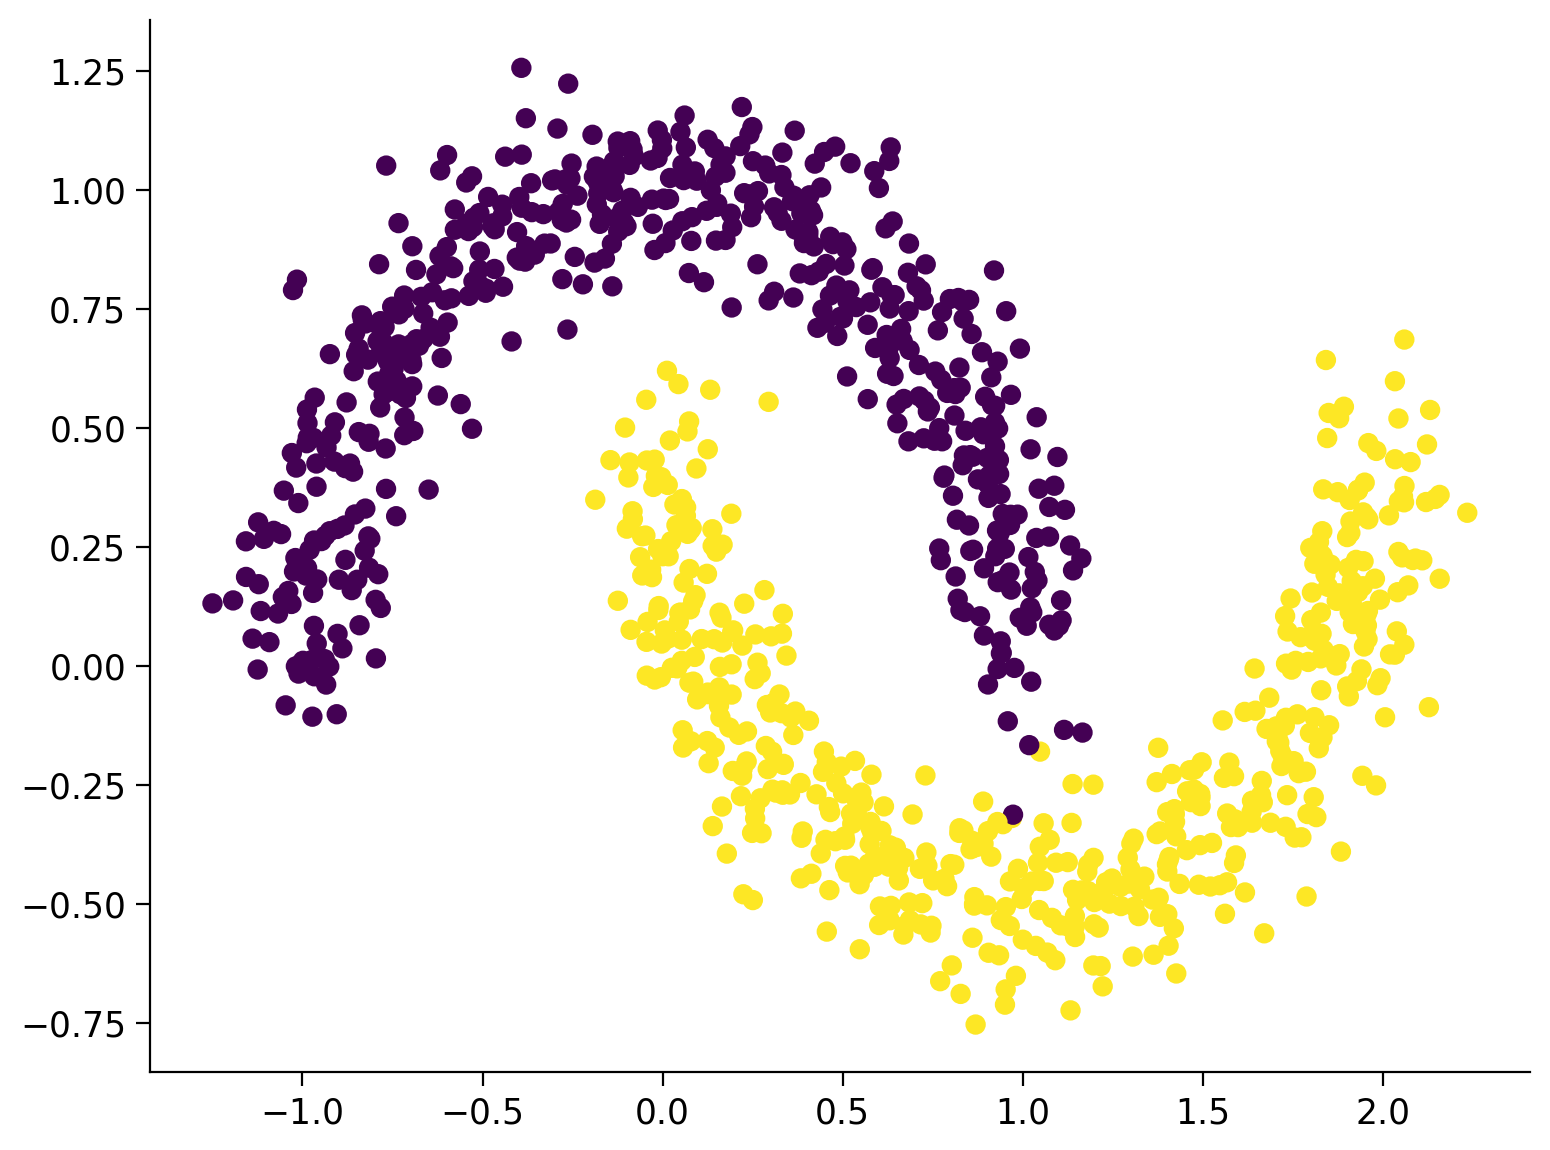

In [10]:
# Load the data from the CSV file in a Pandas DataFrame
data = pd.read_csv("sample_data.csv")

# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")

# Visualize the dataset. The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

**Prepare Data for PyTorch**

Now let's prepare the data in a format suitable for PyTorch - convert everything into tensors.

In [11]:
# Initialize the device variable
DEVICE = set_device()

# Convert the 2D points to a float32 tensor
X = torch.tensor(X_orig, dtype=torch.float32)

# Upload the tensor to the device
X = X.to(DEVICE)

print(f"Size X:{X.shape}")

# Convert the labels to a long interger tensor
y = torch.from_numpy(y_orig).type(torch.LongTensor)

# Upload the tensor to the device
y = y.to(DEVICE)

print(f"Size y:{y.shape}")

# Split the points and labels into train and test sets
X_train = X[:512]
y_train = y[:512]
X_test = X[512:]
y_test = y[512:]

GPU is enabled in this notebook. 
If you want to disable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `None` from the dropdown menu
Size X:torch.Size([1024, 2])
Size y:torch.Size([1024])


## Section 2.2: Create a Simple Neural Network

In [12]:
# @title Video 11: Generating the Neural Network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'PwSzRohUvck'), ('Bilibili', 'BV1fK4y1M74a')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

For this example we want to have a simple neural network consisting of 3 layers:

- 1 input layer of size 2 (our points have 2 coordinates)
- 1 hidden layer of size 16 (you can play with different numbers here)
- 1 output layer of size 2 (we want the have the scores for the two classes)

During the course you will deal with differend kinds of neural networks. On Day 2, we will focus on linear networks, but you will work with some more complicated architectures in the next days. The example here is meant to demonstrate the process of creating and training a neural network end-to-end.

**Programing the Network**

PyTorch provides a base class for all neural network modules called [`nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). You need to inherit from `nn.Module` and implement some important methods:

* `__init__`

  In the `__init__` method you need to define the structure of your network. Here you will specify what layers will the network consist of, what activation functions will be used etc.

* `forward`

  All neural network modules need to implement the `forward` method. It specifies the computations the network needs to do when data is passed through it.

* `predict`

  This is not an obligatory method of a neural network module, but it is a good practice if you want to quickly get the most likely label from the network. It calls the `forward` method and chooses the label with the highest score.

* `train`

  This is also not an obligatory method, but it is a good practice to have. The method will be used to train the network parameters and will be implemented later in the notebook.

<br>

**Note:** You can use the `__call__` method of a module directly and it will invoke the `forward` method: `net()` does the same as `net.forward()`.

In [ ]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveNet(nn.Module):
  """
  NaiveNet architecture
  Structure is as follows:
  Linear Layer (2, 4) -> ReLU activation -> Linear Layer (4, 2)
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveNet structure by initialising following attributes
    nn.Linear (2, 4):  Transformation from the input to the hidden layer
    nn.ReLU: Activation function (ReLU) is a non-linearity which is widely used because it reduces computation.
             The function returns 0 if it receives any negative input, but for any positive value x, it returns that value back.
    nn.Linear (4, 2): Transformation from the hidden to the output layer

    Args:
      None

    Returns:
      Nothing
    """
    super(NaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(2, 4),
        nn.ReLU(),
        nn.Linear(4, 2),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size (B, 2)

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size (B, 2)

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

**Check that your network works**

Create an instance of your model and visualize it.

In [ ]:
# Create new NaiveNet and transfer it to the device
model = NaiveNet().to(DEVICE)

# Print the structure of the network
print(model)

### Coding Exercise 2.2: Classify some samples

Now, let's pass some of the points of our dataset through the network and see if it works. You should not expect the network to actually classify the points correctly, because it has not been trained yet.

The goal here is just to get some experience with the data structures that are passed to the forward and predict methods and their results.

In [ ]:
## Get the first 5 training samples
X_samples = X_train[:5]
print("Sample input:\n", X_samples)

## Do a forward pass of the network
output = model(X_samples)
print("\nNetwork output:\n", output)

## Predict the label of each point
y_predicted = model.predict(X_samples)
y_true = y_train[:5]
print("\nPredicted labels:\n", y_predicted)
print("\True labels:\n", y_true)

## Section 2.3: Train Your Neural Network

In [13]:
# @title Video 12: Train the Network
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '4MIqnE4XPaA'), ('Bilibili', 'BV1v54y1n7CS')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

Now it is time to train your network on your dataset. There is a lot going on here under the hood, but the goal here is just for you to see training in action.

In [ ]:
# Implement the train function given a training dataset X and correcsponding labels y
def train(model, X, y):
  """
    Training the Neural Network

    Args:
      X: torch.Tensor
        Input data
      y: torch.Tensor
        Class Labels/Targets

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 15000

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    # Pass the data through the network and compute the loss
    # We'll use the whole dataset during the training instead of using batches
    # in to order to keep the code simple for now.
    y_logits = model.forward(X)
    loss = loss_function(y_logits, y)

    # Clear the previous gradients and compute the new ones
    optimizer.zero_grad()
    loss.backward()

    # Adapt the weights of the network
    optimizer.step()

    # Store the loss
    losses.append(loss.item())

    # Print the results at every 1000th epoch
    if i % 1000 == 0:
      print(f"Epoch {i} loss is {loss.item()}")

      plot_decision_boundary(model, X, y, DEVICE)
      plt.savefig('frames/{:05d}.png'.format(i))

  return losses


# Create a new network instance a train it
set_seed(42)
model = NaiveNet().to(DEVICE)
losses = train(model, X_train, y_train)

**Plot the loss during training**

Plot the loss during the training to see how it reduces and converges.

In [ ]:
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
# @title Visualize the training process
# @markdown Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio.v2 as imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = Path("frames/0"+str(i)+"000.png")
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimwrite('frames/movie.gif', images, loop=0)
gif_path = Path("frames/movie.gif")
# with open(gif_path,'rb') as f:
display(Image(gif_path))

In [ ]:
# @title Visualize the test set
plot_decision_boundary(model, X_test, y_test, DEVICE)

### Exercise 2.3: Tweak your Network

You can now play around with the network a little bit to get a feeling of what the different pieces are doing.
**Take a look at [this website](https://playground.tensorflow.org/#activation=tanh&batchSize=30&dataset=spiral&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=25&networkShape=4,2&seed=0.12115&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&dataset_hide=true&problem_hide=true&percTrainData_hide=true&noise_hide=true)!** You can play with the layers, see what every layer is doing, and even see the weights between neurons and edit them
on the fly. This should give you some ideas to improve your network when you come back here.

Some things to think about:

1. What are some of the things you could play with in the neural network?
2. Can you modify the network to better fit the data?
3. Why did what you tried improve (or worsen) your results?

In [ ]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class LessNaiveNet(nn.Module):
  """
  LessNaiveNet architecture
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the LessNaiveNet structure.

    Args:
      None

    Returns:
      Nothing
    """
    super(LessNaiveNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        # FILL IN YOUR NETWORK HERE
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size (B, 2)

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size (B, 2)

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

In [ ]:
# @title Train your new network!
set_seed(42)
model = LessNaiveNet().to(DEVICE)
losses = train(model, X_train, y_train)

In [ ]:
_ = plt.plot(np.linspace(1, len(losses), len(losses)), losses)
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Loss")

In [ ]:
# @title Visualize the training process
# @markdown Execute this cell!
!pip install imageio --quiet
!pip install pathlib --quiet

import imageio.v2 as imageio
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import Image, display
from pathlib import Path

InteractiveShell.ast_node_interactivity = "all"

# Make a list with all images
images = []
for i in range(10):
  filename = Path("frames/0"+str(i)+"000.png")
  images.append(imageio.imread(filename))
# Save the gif
imageio.mimwrite('frames/movie.gif', images, loop=0)
gif_path = Path("frames/movie.gif")
# with open(gif_path,'rb') as f:
display(Image(gif_path))

In [ ]:
# @title Visualize the test set
plot_decision_boundary(model, X_test, y_test, DEVICE)

---
# Section 3: Convolutional Neural Networks

We've dealt with data given as a set of features (in this case just 2D coordinates), but now let's see how we can design neural networks that deal with images.

In this section, you'll create your own simple convolutional neural network to classify handwritten digits, using a classic computer vision dataset: MNIST.
In addition to learning how to build convolutional neural networks, you'll see how to handle training on data without going through the whole dataset each time by batching the data.

## Section 3.1: Data Loading

Let's load the MNIST handwritten digit dataset. Luckily, PyTorch comes with the MNIST dataset built in:

In [14]:
# @title Generate sample data
# @markdown we used `scikit-learn` module
mnist_train = datasets.MNIST("./", train=True, download=True, transform=lambda x: np.array(x, dtype=np.float32) / 255)
mnist_test = datasets.MNIST("./", train=False, download=True, transform=lambda x: np.array(x, dtype=np.float32) / 255)

Let's take a look at a few digits from the dataset:

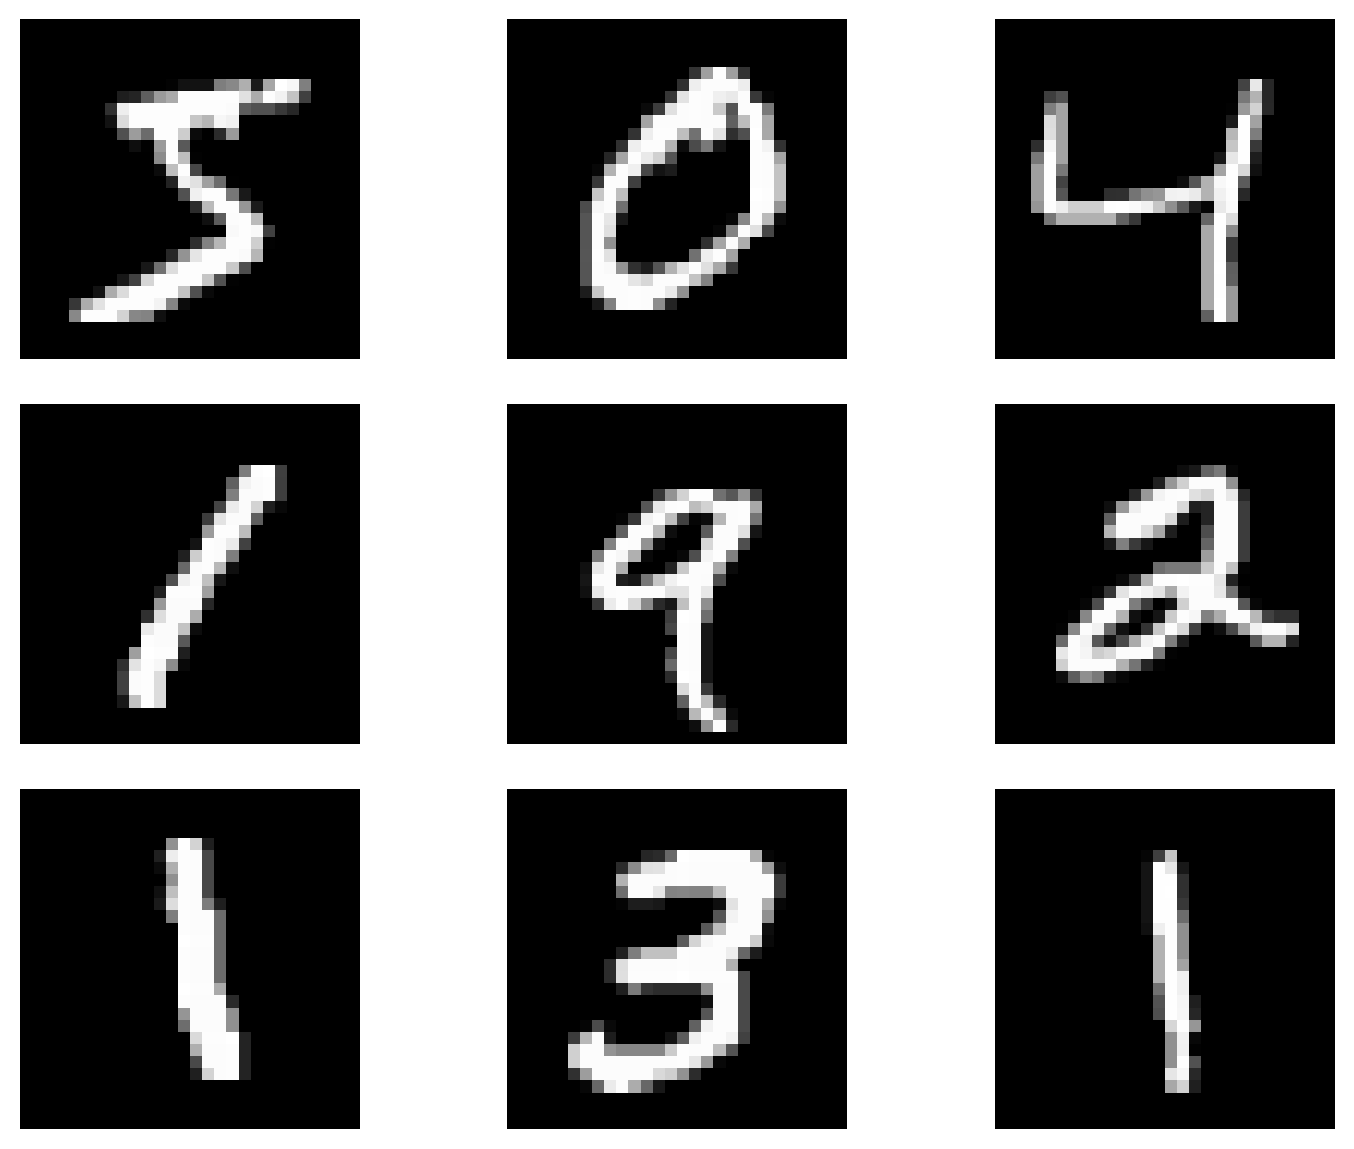

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3)
axes = np.ravel(axes)
counter = 0
for image, label in mnist_train:
    ax = axes[counter]
    _ = ax.imshow(image, cmap="gray")
    _ = ax.axis("off")
    counter += 1
    if counter >= 9:
        break
plt.tight_layout()
plt.show()

We need to create a loader for this data so that PyTorch can automatically create batches for us:

In [ ]:
train_dataloader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=None, shuffle=False)

## Section 3.2: Training bad networks for MNIST

Here, we'll walk you through the training process for MNIST, which works very similarly to the way you just trained for the last dataset. This time however, you'll see that the network has to output a likelihood for 10 classes instead of 2.

## Demo 3.2: Train an MLP to solve MNIST

Let's first see what happens if we try to solve MNIST using a small MLP:

In [ ]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class NaiveMNISTNet(nn.Module):
  """
  NaiveMNISTNet architecture
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the NaiveMNISTNet structure.

    Args:
      None

    Returns:
      Nothing
    """
    super(NaiveMNISTNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Linear(28 * 28, 10),
        nn.ReLU(),
        nn.Linear(10, 10),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    x = x.reshape(-1, 28 * 28) # The image needs to be flattened into a vector!
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

In [ ]:
# Implement the train function given a training dataset X and corresponding labels y
def batch_train(model, dataloader, device):
  """
    Training the Neural Network

    Args:
      dataloader: torch.utils.data.DataLoader
        Loader that returns batches of inputs and labels from a Dataset

    Returns:
      losses: Float
        Cross Entropy Loss; Cross-entropy builds upon the idea of entropy
        from information theory and calculates the number of bits required
        to represent or transmit an average event from one distribution
        compared to another distribution.
    """
  # The Cross Entropy Loss is suitable for classification problems
  loss_function = nn.CrossEntropyLoss()

  # Create an optimizer (Stochastic Gradient Descent) that will be used to train the network
  learning_rate = 1e-2
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  # Number of epochs
  epochs = 25

  # List of losses for visualization
  losses = []

  for i in range(epochs):
    epoch_losses = []
    for X, y in dataloader:
        # Move batch to GPU if available
        # For MNIST, moving the data to GPU each time is actually slow!
        # We could fit the whole dataset on the GPU and skip this step
        # since the dataset is so small, but that's fine for now.
        X = X.to(device)
        y = y.to(device)
        # Pass the data through the network and compute the loss
        y_logits = model.forward(X)
        loss = loss_function(y_logits, y)
    
        # Clear the previous gradients and compute the new ones
        optimizer.zero_grad()
        loss.backward()
    
        # Adapt the weights of the network
        optimizer.step()
    
        # Store the loss
        epoch_losses.append(loss.item())

    # Print the results at every epoch
    epoch_loss = np.mean(np.array(epoch_losses))
    losses.append(epoch_loss)
    print(f"Epoch {i} loss is {epoch_loss.item()}")

  return losses

# Create a new network instance a train it
set_seed(42)
model = NaiveMNISTNet().to(DEVICE)
losses = batch_train(model, train_dataloader, DEVICE)

In [ ]:
_ = plt.plot(np.linspace(1, len(losses), len(losses)), losses)
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Loss")

In [ ]:
# @title Visualize performance on test set
fig, axes = plt.subplots(nrows=3, ncols=3)
axes = np.ravel(axes)
counter = 0
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    color = "black" if prediction == label else "red"
    ax = axes[counter]
    _ = ax.imshow(image, cmap="gray")
    _ = ax.axis("off")
    _ = ax.set_title(f"prediction: {prediction}", color=color)
    counter += 1
    if counter >= 9:
        break
plt.tight_layout()
plt.show()

In [ ]:
# @title Quantify performance on test set
test_predictions = []
test_labels = []
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    test_labels.append(label)
    test_predictions.append(prediction.item())
cm = confusion_matrix(test_labels, test_predictions, labels=np.arange(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
_ = disp.plot()
plt.show()
print(f"Accuracy on MNIST: {accuracy_score(test_labels, test_predictions)}")

## Demo 3.2: Train a CNN to solve MNIST

Now, let's just walk through how to use convolution layers in PyTorch to make a convolutional neural network. Convolutional neural networks are the go-to choice when working with image data in deep learning. We'll start out with a small set of . Think about what each layer here is doing and why we need it!

In [ ]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class AnotherNaiveMNISTNet(nn.Module):
  """
  AnotherNaiveMNISTNet architecture
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the AnotherNaiveMNISTNet structure.

    Args:
      None

    Returns:
      Nothing
    """
    super(AnotherNaiveMNISTNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        nn.Conv2d(1, 5, 3, padding="same"),
        nn.ReLU(),
        nn.Conv2d(5, 1, 3, padding="same"),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(28 * 28, 10),
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    x = x.unsqueeze(1) # We need to add a channel dimension for PyTorch convolutions!
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

In [ ]:
# Create a new network instance a train it
set_seed(42)
model = AnotherNaiveMNISTNet().to(DEVICE)
losses = batch_train(model, train_dataloader, DEVICE)

In [ ]:
_ = plt.plot(np.linspace(1, len(losses), len(losses)), losses)
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Loss")

In [ ]:
# @title Visualize performance on test set
fig, axes = plt.subplots(nrows=3, ncols=3)
axes = np.ravel(axes)
counter = 0
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    color = "black" if prediction == label else "red"
    ax = axes[counter]
    _ = ax.imshow(image, cmap="gray")
    _ = ax.axis("off")
    _ = ax.set_title(f"prediction: {prediction}", color=color)
    counter += 1
    if counter >= 9:
        break
plt.tight_layout()
plt.show()

In [ ]:
# @title Quantify performance on test set
test_predictions = []
test_labels = []
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    test_labels.append(label)
    test_predictions.append(prediction.item())
cm = confusion_matrix(test_labels, test_predictions, labels=np.arange(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
_ = disp.plot()
plt.show()
print(f"Accuracy on MNIST: {accuracy_score(test_labels, test_predictions)}")

### Exercise 3.2: Improve MNIST performance

Now, create a better convolutional neural network to solve MNIST! You'll want to check out the [documentation for convolutions](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) in PyTorch.

Some questions that you could think about:
1. How many convolutional layers should you add?
2. What kernel size should you use?
3. How many feature maps should you use?
4. What's the right way to choose amongst these different settings?
5. Could you have improved the MLP instead? What other architectures can you think of?

In [ ]:
# Inherit from nn.Module - the base class for neural network modules provided by Pytorch
class LessNaiveMNISTNet(nn.Module):
  """
  LessNaiveMNISTNet architecture
  """
  # Define the structure of your network
  def __init__(self):
    """
    Defines the LessNaiveMNISTNet structure.

    Args:
      None

    Returns:
      Nothing
    """
    super(LessNaiveMNISTNet, self).__init__()

    # The network is defined as a sequence of operations
    self.layers = nn.Sequential(
        # FILL IN YOUR NETWORK HERE
    )

  # Specify the computations performed on the data
  def forward(self, x):
    """
    Defines the forward pass through the above defined structure

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      layers: nn.module
        Initialised Layers in order to re-use the same layer for each forward pass of data you make.
    """
    # Pass the data through the layers
    x = x.unsqueeze(1) # We need to add a channel dimension for PyTorch convolutions!
    return self.layers(x)

  # Choose the most likely label predicted by the network
  def predict(self, x):
    """
    Performs the prediction task of the network

    Args:
      x: torch.Tensor
        Input tensor of size (B, 28, 28)

    Returns:
      Most likely class i.e., Label with the highest score
    """
    # Pass the data through the networks
    output = self.forward(x)

    # Choose the label with the highest score
    return torch.argmax(output, 1)

In [ ]:
# Create a new network instance a train it
set_seed(42)
model = LessNaiveMNISTNet().to(DEVICE)
losses = batch_train(model, train_dataloader, DEVICE)

In [ ]:
_ = plt.plot(np.linspace(1, len(losses), len(losses)), losses)
_ = plt.xlabel("Epoch")
_ = plt.ylabel("Loss")

In [ ]:
# @title Visualize performance on test set
fig, axes = plt.subplots(nrows=3, ncols=3)
axes = np.ravel(axes)
counter = 0
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    color = "black" if prediction == label else "red"
    ax = axes[counter]
    _ = ax.imshow(image, cmap="gray")
    _ = ax.axis("off")
    _ = ax.set_title(f"prediction: {prediction}", color=color)
    counter += 1
    if counter >= 9:
        break
plt.tight_layout()
plt.show()

In [ ]:
# @title Quantify performance on test set
test_predictions = []
test_labels = []
for image, label in test_dataloader:
    prediction = model.predict(image.to(DEVICE).unsqueeze(0)).squeeze()
    test_labels.append(label)
    test_predictions.append(prediction.item())
cm = confusion_matrix(test_labels, test_predictions, labels=np.arange(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
_ = disp.plot()
plt.show()
print(f"Accuracy on MNIST: {accuracy_score(test_labels, test_predictions)}")

---
# Bonus - 60 years of Machine Learning Research in one Plot

By [Hendrik Strobelt](http://hendrik.strobelt.com) (MIT-IBM Watson AI Lab) with support from Benjamin Hoover.

In this notebook we visualize a subset* of 3,300 articles retreived from the AllenAI [S2ORC dataset](https://github.com/allenai/s2orc). We represent each paper by a position that is output of a dimensionality reduction method applied to a vector representation of each paper. The vector representation is the output of a neural network.

**Note:** The selection is very biased on the keywords and methodology we used to filter. Please see the details section to learn about what we did.

In [16]:
# @title Install and Import `altair` and `vega_datasets`.
!pip install altair vega_datasets --quiet

import altair as alt  # altair is defining data visualizations

# Source data files
# Position data file maps ID to x,y positions
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc.pos_umap_cosine_100_d0.1.json
POS_FILE = 'https://osf.io/qyrfn/download'
# original link: http://gltr.io/temp/ml_regexv1_cs_ma_citation+_99perc_clean.csv
# Metadata file maps ID to title, abstract, author,....
META_FILE = 'https://osf.io/vfdu6/download'

# data loading and wrangling
def load_data():
  """
  Loading the data

  Args:
    None

  Returns:
    Merged read dataFrame combining id and paper_id;
  """
  positions = pd.read_json(POS_FILE)
  positions[['x', 'y']] = positions['pos'].to_list()
  meta = pd.read_csv(META_FILE)
  return positions.merge(meta, left_on='id', right_on='paper_id')


# load data
data = load_data()

In [21]:
# @title Define Visualization using ALtair
YEAR_PERIOD = "quinquennial"  # @param
selection = alt.selection_point(fields=[YEAR_PERIOD], bind='legend')
data[YEAR_PERIOD] = (data["year"] / 5.0).apply(np.floor) * 5
chart = alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count"]], width=800,
                  height=800).mark_circle(radius=2, opacity=0.2).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False, clamp=True, domain=list(range(1955,2020,5))),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
       alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
       alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
    # size='citation_count',
    # color="decade:O",
    opacity=alt.condition(selection, alt.value(.8), alt.value(0.2)),

).add_params(
    selection
).interactive()

Lets look at the Visualization. Each dot represents one paper. Close dots mean that the respective papers are closer related than distant ones. The color indicates the 5-year period of when the paper was published. The dot size indicates the citation count (within S2ORC corpus) as of July 2020.

The view is **interactive** and allows for three main interactions. Try them and play around:
1. Hover over a dot to see a tooltip (title, author)
2. Select a year in the legend (right) to filter dots
3. Zoom in/out with scroll -- double click resets view

In [23]:
chart

alt.Chart(...)

## Questions

By playing around, can you find some answers to the following questions?

1. Can you find topical clusters? What cluster might occur because of a filtering error?
2. Can you see a temporal trend in the data and clusters?
3. Can you determine when deep learning methods started booming ?
4. Can you find the key papers that where written before the DL "winter" that define milestones for a cluster? (tip: look for large dots of different color)

## Methods

Here is what we did:
1. Filtering of all papers who fullfilled the criterria:
  - are categorized as `Computer Science` or `Mathematics`
  - one of the following keywords appearing in title or abstract: `"machine learning|artificial intelligence|neural network|(machine|computer) vision|perceptron|network architecture| RNN | CNN | LSTM | BLEU | MNIST | CIFAR |reinforcement learning|gradient descent| Imagenet "`
2. Per year, remove all papers that are below the 99 percentile of citation count in that year
3. Embed each paper by using abstract + title in SPECTER model
4. Project based on embedding using UMAP
5. Visualize using Altair

### Find Authors

In [ ]:
# @title Edit the `AUTHOR_FILTER` variable to full text search for authors.

AUTHOR_FILTER = "Rush "  # @param space at the end means "word border"

### Don't ignore case when searching...
FLAGS = 0
### uncomment do ignore case
# FLAGS = re.IGNORECASE

## --- FILTER CODE.. make it your own ---
data['issel'] = data['authors'].str.contains(AUTHOR_FILTER, na=False, flags=FLAGS, )
if data['issel'].mean()<0.0000000001:
  print('No match found')

## --- FROM HERE ON VIS CODE ---
alt.Chart(data[["x", "y", "authors", "title", YEAR_PERIOD, "citation_count", "issel"]], width=800,
                  height=800) \
    .mark_circle(stroke="black", strokeOpacity=1).encode(
    alt.Color(YEAR_PERIOD+':O',
              scale=alt.Scale(scheme='viridis', reverse=False),
              # legend=alt.Legend(title='Total Records')
              ),
    alt.Size('citation_count',
              scale=alt.Scale(type="pow", exponent=1, range=[15, 300])
              ),
    alt.StrokeWidth('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[0, 2]), legend=None),

    alt.Opacity('issel:Q', scale=alt.Scale(type="linear", domain=[0,1], range=[.2, 1]), legend=None),
    alt.X('x:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    alt.Y('y:Q',
        scale=alt.Scale(zero=False), axis=alt.Axis(labels=False)
    ),
    tooltip=['title', 'authors'],
).interactive()

---
# Appendix

## Official PyTorch resources:

### Tutorials
- [https://pytorch.org/tutorials/](https://pytorch.org/tutorials/)

### Documentation
- [https://pytorch.org/docs/stable/tensors.html](https://pytorch.org/docs/stable/tensors.html) (tensor methods)

- [https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view) (The view method in particular)

- [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html) (pre-loaded image datasets)

## Google Colab Resources:
- [https://research.google.com/colaboratory/faq.html](https://research.google.com/colaboratory/faq.html) (FAQ including guidance on GPU usage)

## Books for reference:
- [https://www.deeplearningbook.org/](https://www.deeplearningbook.org/) (Deep Learning by Ian Goodfellow, Yoshua Bengio and Aaron Courville)